This is not the main notebook in this challenge. See `rl-train-d20.ipynb`.

## Review run

Review the RL training run in `rl-train-d20.ipynb`.

High level...this is the most "fun" of the trainings done so far: base, mid, sft, rl. There's something so satisfying about knowing the model is actually generating answers, some of the times they are actually correct, and over the course of the training we make the model better at giving more correct answers.

Going to list out a bunch of observations and then dig in.

1) GSM8K accuracy went up from 5% to 8.8%. There are 1319 examples in the test set (see `challenge-27-understand-chat-eval/chat-eval-data-examples.ipynb`) so that means we went from getting 75 right to 116 right. This seems good. ARC-Challenge, ARC-Easy and MMLU did not change by "much" which seems expected/good I guess. However, HumanEval was halved from getting 10 problems right to 5 problems right. Curious why that is. Overall ChatCORE was about the same because the big improvement in GSM8K was offset by HumanEval.

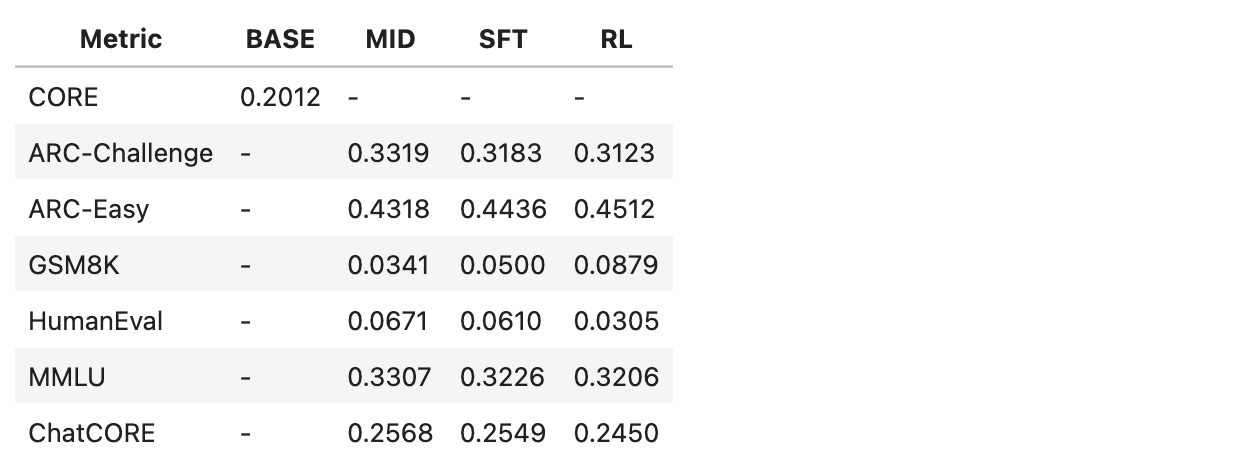

2) Why did pass@k go down after step 240? Here are the graphs for pass@8, 7, 6 but the same is also true for pass@5, 4, 3, 2, 1.

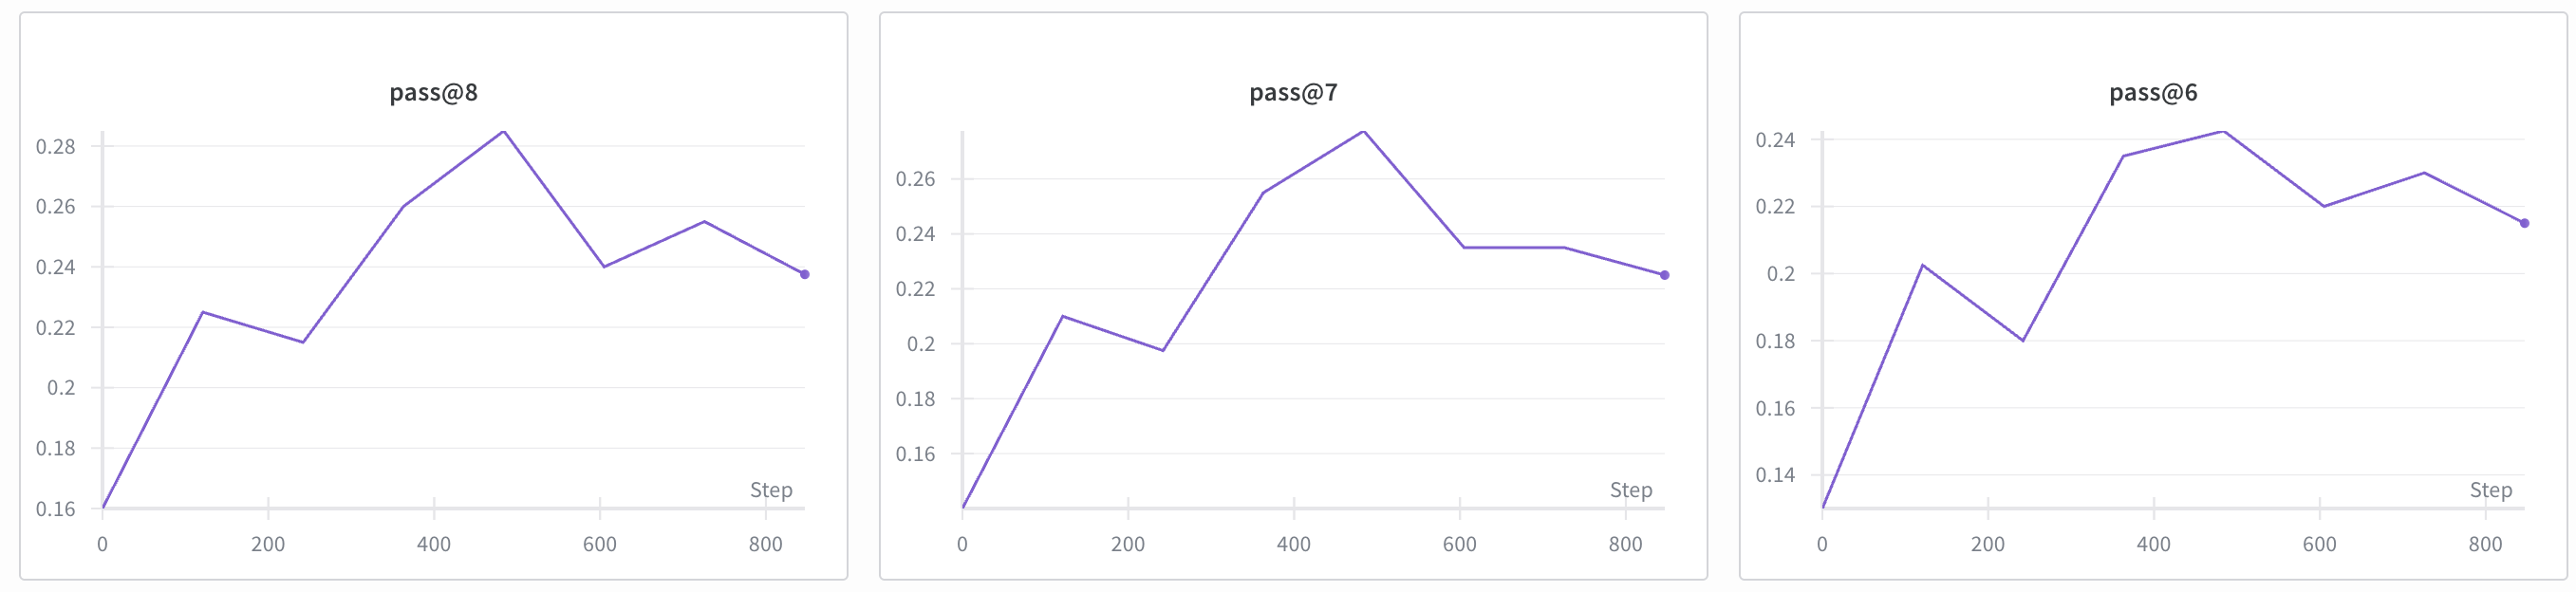

3) The loss shown in output is often a negative number close to zero. Is this expected?

```
Step 431/467 | Example step 0 | Pass 0 | loss: -0.000000 | average reward: 0.0
Step 431/467 | Example step 0 | Pass 1 | loss: -0.000000 | average reward: 0.0
Step 431/467 | Example step 1 | Pass 0 | loss: 0.009191 | average reward: 0.375
Step 431/467 | Example step 1 | Pass 1 | loss: -0.005805 | average reward: 0.125
```

4) Is it expected for averge sequence length to decline over the first ~fifth of the training? Is this the model getting trained to give better and more concise answers vs "going crazy", or something about the examples themselves, or ... ?

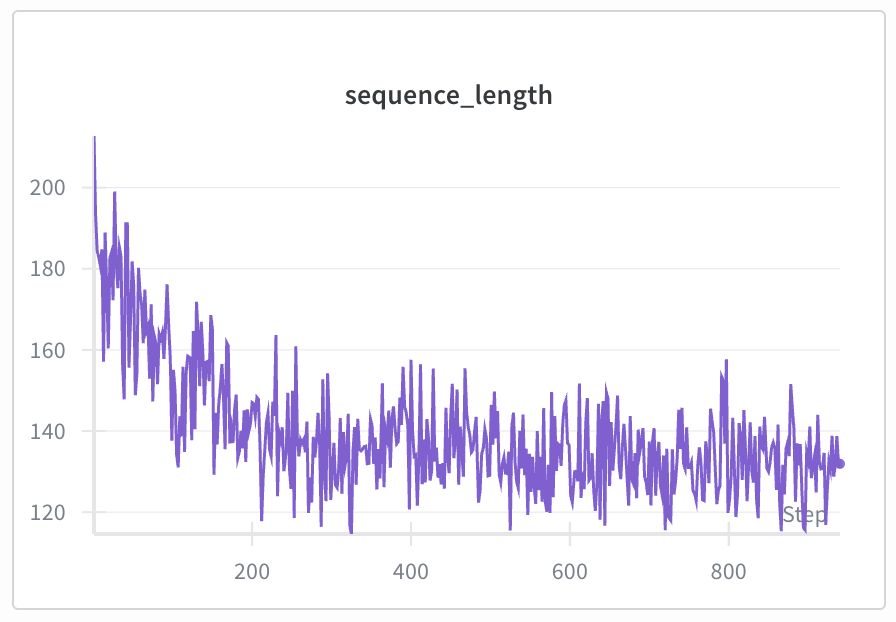
   
5) Is it expected for reward to trend up?

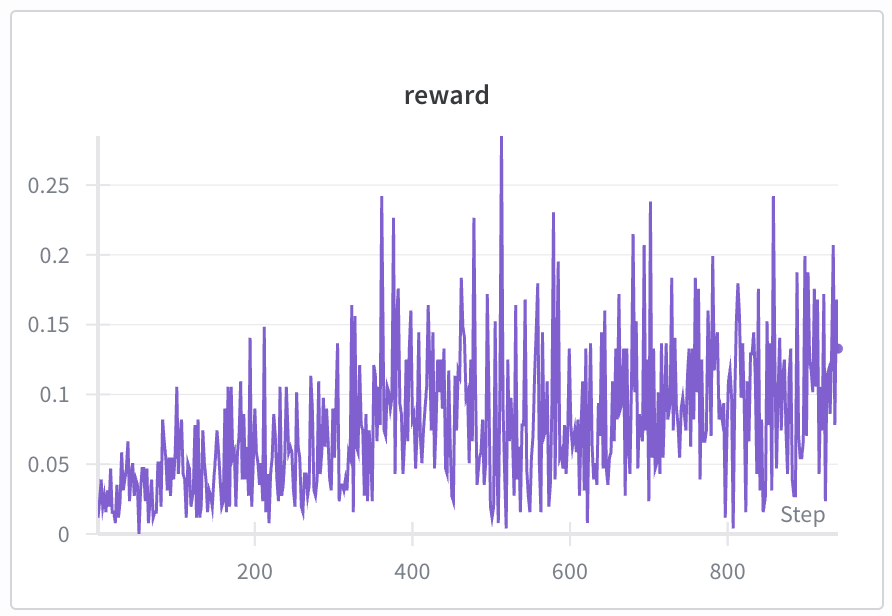

Start with #3.

### #3 

The loss shown in output is often a negative number close to zero. Is this expected?

```
Step 431/467 | Example step 0 | Pass 0 | loss: -0.000000 | average reward: 0.0
Step 431/467 | Example step 0 | Pass 1 | loss: -0.000000 | average reward: 0.0
Step 431/467 | Example step 1 | Pass 0 | loss: 0.009191 | average reward: 0.375
Step 431/467 | Example step 1 | Pass 1 | loss: -0.005805 | average reward: 0.125
```

To remember...what exactly is that loss? It's the loss for a single batch on one rank. Our device batch size is set to 8, and we are generating 16 samples per example, so this means a single row in that printout is the loss for half of the samples for an example.

Say of 8 samples they are all wrong. Then rewards will be [0,0,0,0,0,0,0,0], mu will be 0, and advantages will also be [0,0,0,0,0,0,0,0]. This makes sense because we have no information that would want us to push the model to say that one sample is better or worse than another. So now whatever the "underlying" cross-entry loss per token, pg_obj will be 0 and loss is -pg_obj. Gradient should be all 0s...

In [18]:
import torch
model = torch.nn.Linear(in_features=2, out_features=1, bias=False)
x = torch.randn(2)
loss = 5 - model(x)
loss.backward()
model.weight.grad

tensor([[-1.3129,  0.8850]])

In [19]:
model.zero_grad()
loss = model(x) * 0
loss.backward()
model.weight.grad

tensor([[0., 0.]])

Now say 1 of the 8 samples is right and the others are wrong. Then rewards could be [0,1,0,0,0,0,0,0], mu will be 1/8 and advantages will be [-0.125, 0.875, -0.125, ...]. 

Remember how cross entropy loss is a calculated...

In [30]:
torch.nn.functional.cross_entropy(torch.tensor([[0.2,0.3,0.4]]),torch.tensor([1]))

tensor(1.1019)

In [37]:
import math
-math.log(math.exp(0.3) / (math.exp(0.2) + math.exp(0.3) + math.exp(0.4)))

1.1019428482292442

Let's say the sum of the cross entropy loss for the correct sample was better (lower) than all of the other 7 like [1.2, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2], so when we negate and multiply:

In [41]:
temp = -torch.tensor([1.2, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]) * \
torch.tensor([-0.125, 0.875, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125])
temp

tensor([ 0.1500, -0.9625,  0.1500,  0.1500,  0.1500,  0.1500,  0.1500,  0.1500])

In [44]:
-temp.sum() / 8

tensor(-0.0109)

And since we normalize and negate again, ending up with a negative number seems legit and not concerning.

Now suppose the "underlying" cross entropy loss was worse for the correct one. We should expect the loss to be higher because the model is doing worse.

In [46]:
temp = -torch.tensor([1.1, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]) * \
torch.tensor([-0.125, 0.875, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125])
-temp.sum() / 8

tensor(0.0109)

So the loss printouts all seem fine, things working as expected.

### #4

Is it expected for averge sequence length to decline over the first ~fifth of the training? Is this the model getting trained to give better and more concise answers vs "going crazy", or something about the examples themselves, or ... ?

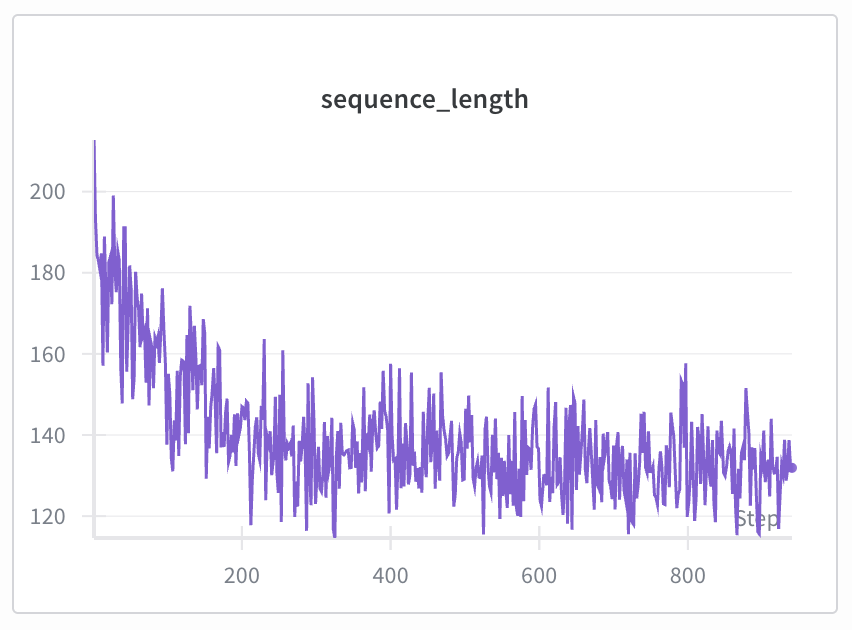

See what sequence_length logged to wandb is exactly. It is the average sequence length of all samples generated on all ranks for a step. We are doing 16 examples per step, and 16 samples per example, so it's the average of 256 token sequences. These sequences include the "prompt" and the completion, in other words the user question and the assistant response. We generate a max new tokens of 256 so no sequence can be longer than the length of the "prompt" in tokens plus 256.

A theory for why the average goes down at first is what I mentioned above. Maybe you ask a word problem like "Lorraine and Colleen are trading stickers for buttons. Each large sticker is worth a large button or three small buttons. A small sticker is worth one small button. A large button is worth three small stickers. Lorraine starts with 30 small stickers and 40 large stickers. She trades 90% of her small stickers for large buttons. She trades 50% of her large stickers for large buttons and trades the rest of them for small buttons. How many buttons does she have by the end?"

Maybe sometimes the model tends to spew out of lot of stuff, get into a cycle, "lose itself" in the problem, or something like that tends to lead to long sequences and wrong answers. As the training works the model gets trained away from doing that.

Another possibility is that the prompts and/or the tokens required to solve a problem shrink as we go through the data, but I think can dismiss that becuase the training set is randomly ordered.

TODO: come back to this once back on the GPU machine. Try logging examples of especially long sequences to see if there are clues. Another thing to try is like that but for the validation set so can compare length of generated sequence for the exact same problems at 60 steps, 120 steps, etc.

### #5

Is it expected for reward to trend up?

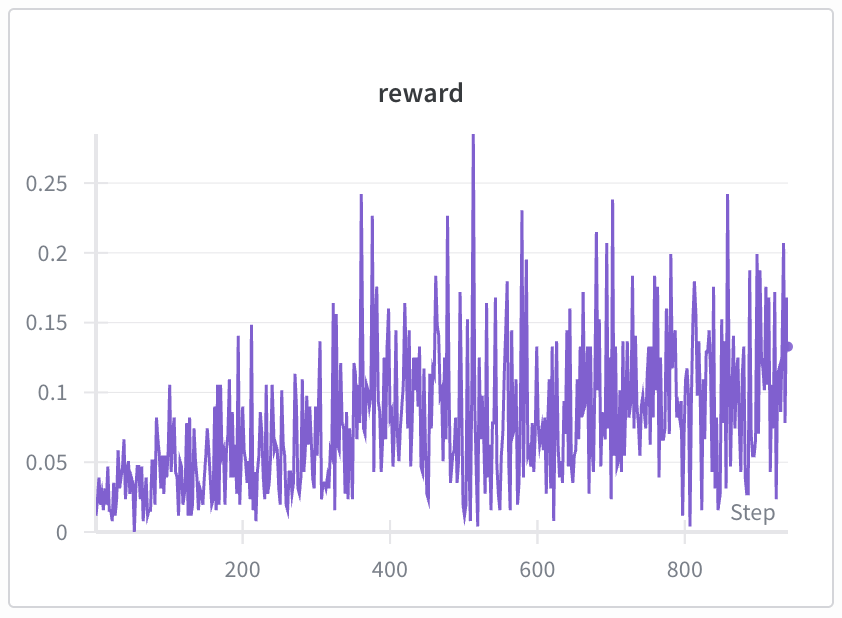

What exactly do we log to wandb? It's very similar to sequence length. It's the mean reward across all examples in a step across all ranks. So for each step it's the mean of 256 rewards, that 16 rewards for each of 16 examples.

It makes sense that it trends up. As we start doing better, more samples will be correct. The minimum possible is 0 and the max is 1 becuase we're taking the mean across 0s and 1s.

It does looks it trends up over the entire training, but we know that pass@k on the validation set drops after a certain number of steps. It smells like overfitting, and maybe a form of it, but weird becuase we only see each training example once and the validation and training are randomly chosen from the same overall set of examples.

### #2

Why did pass@k go down after step 240?

(Fixed the x-axis on these)

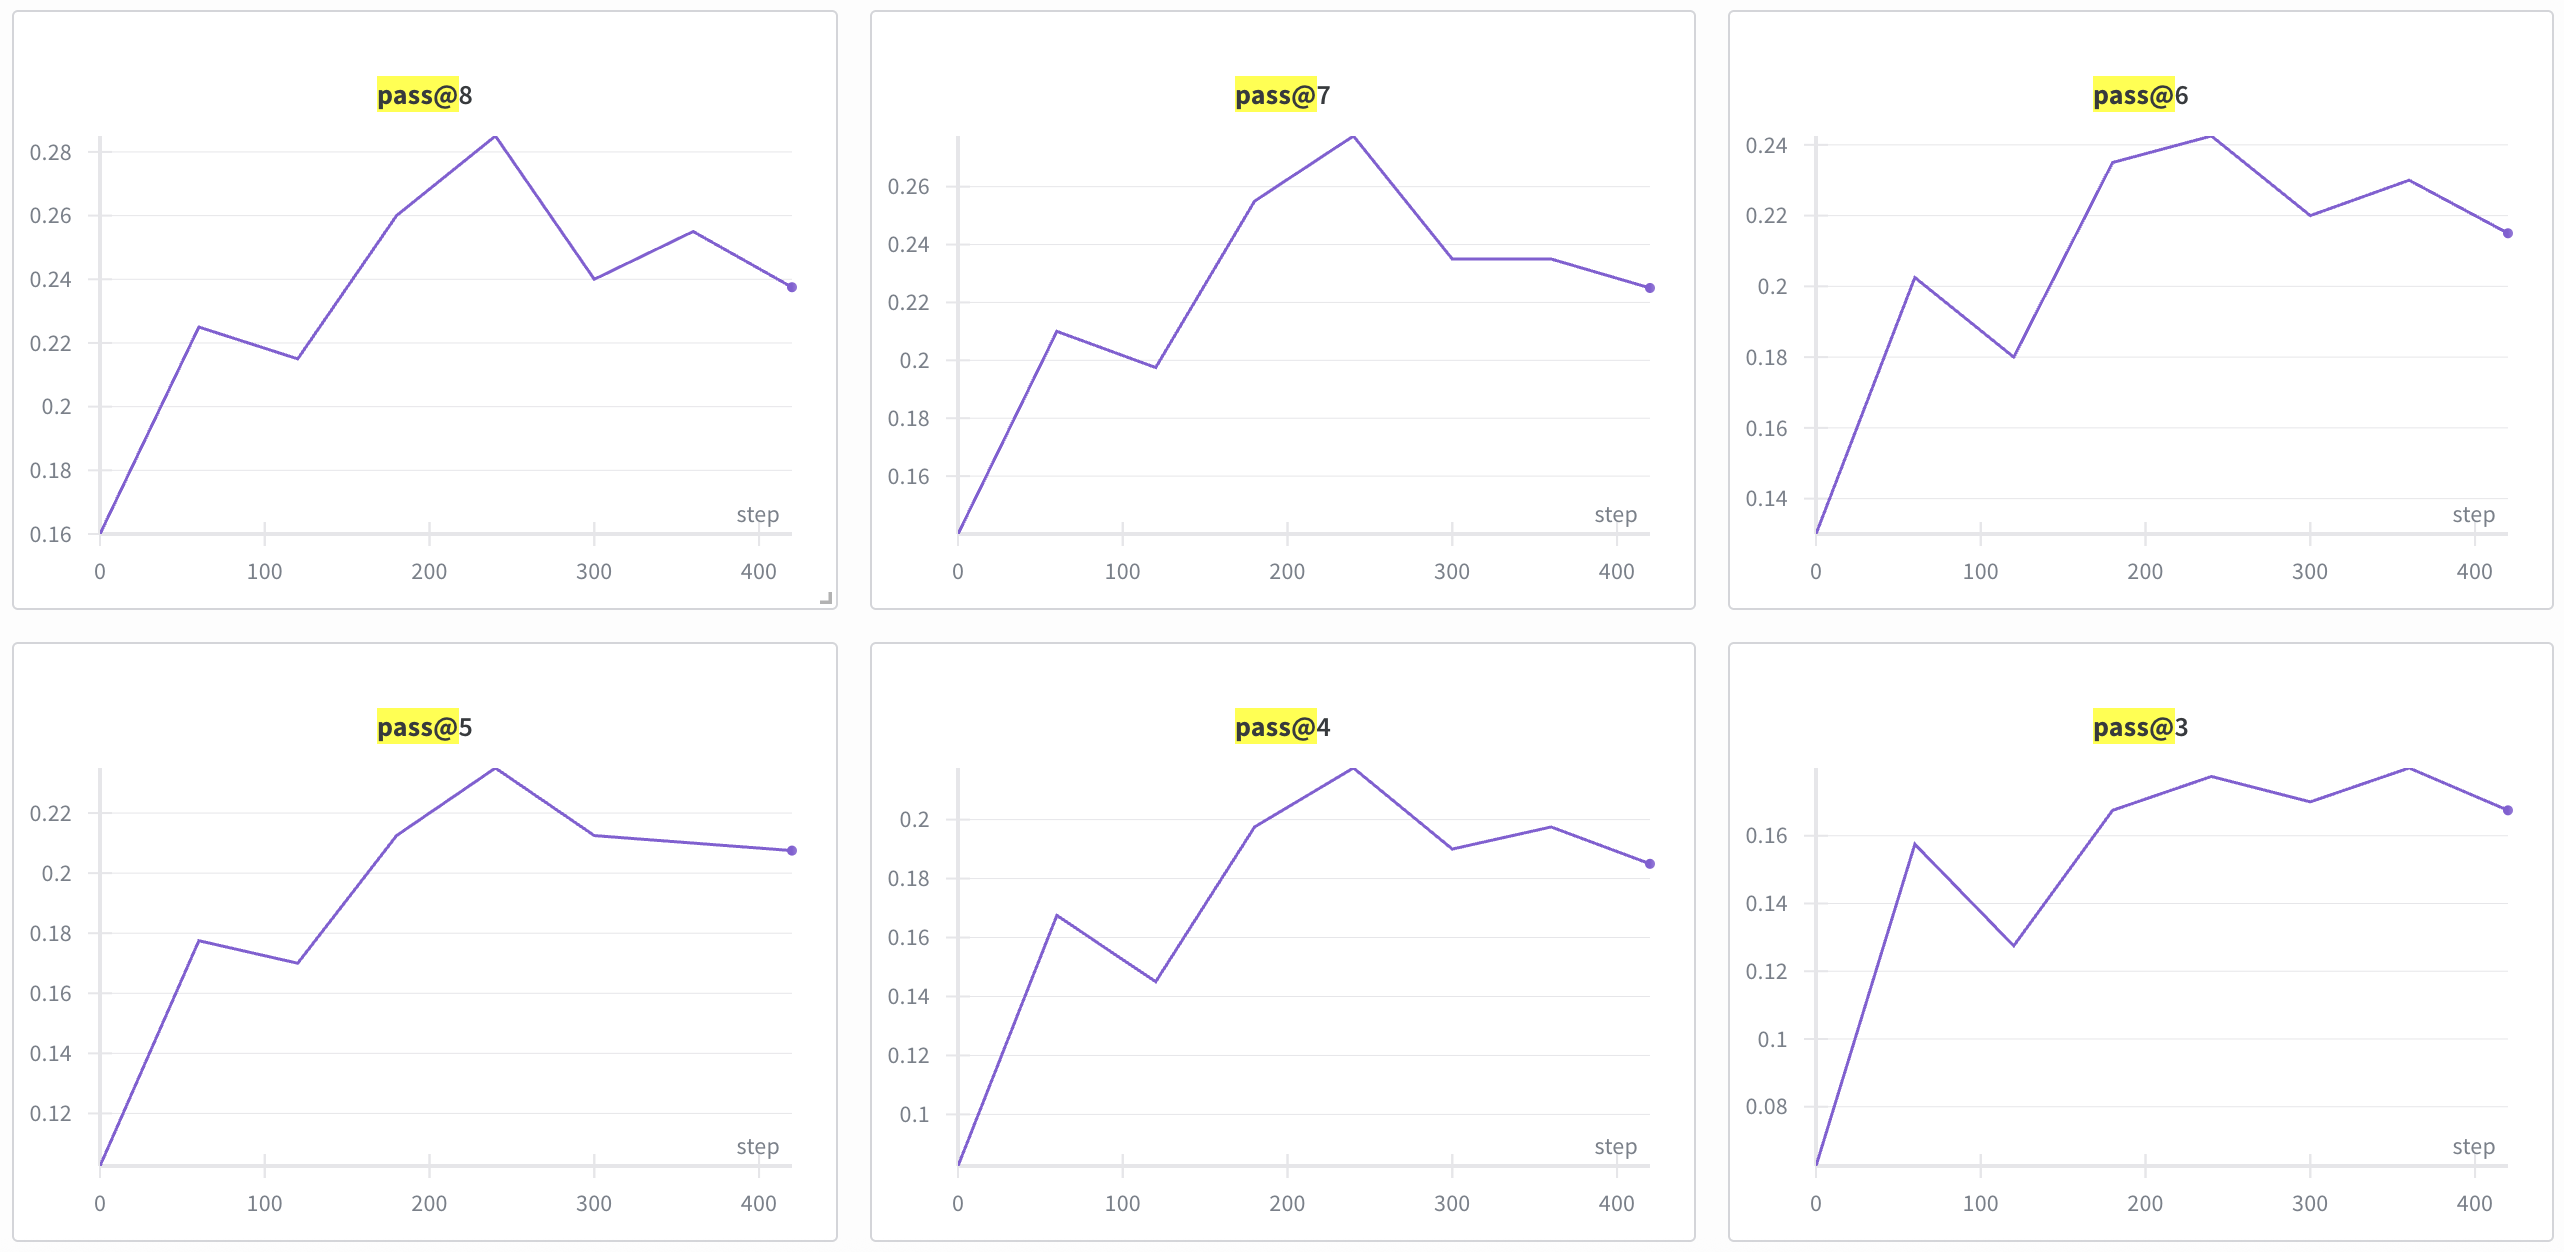

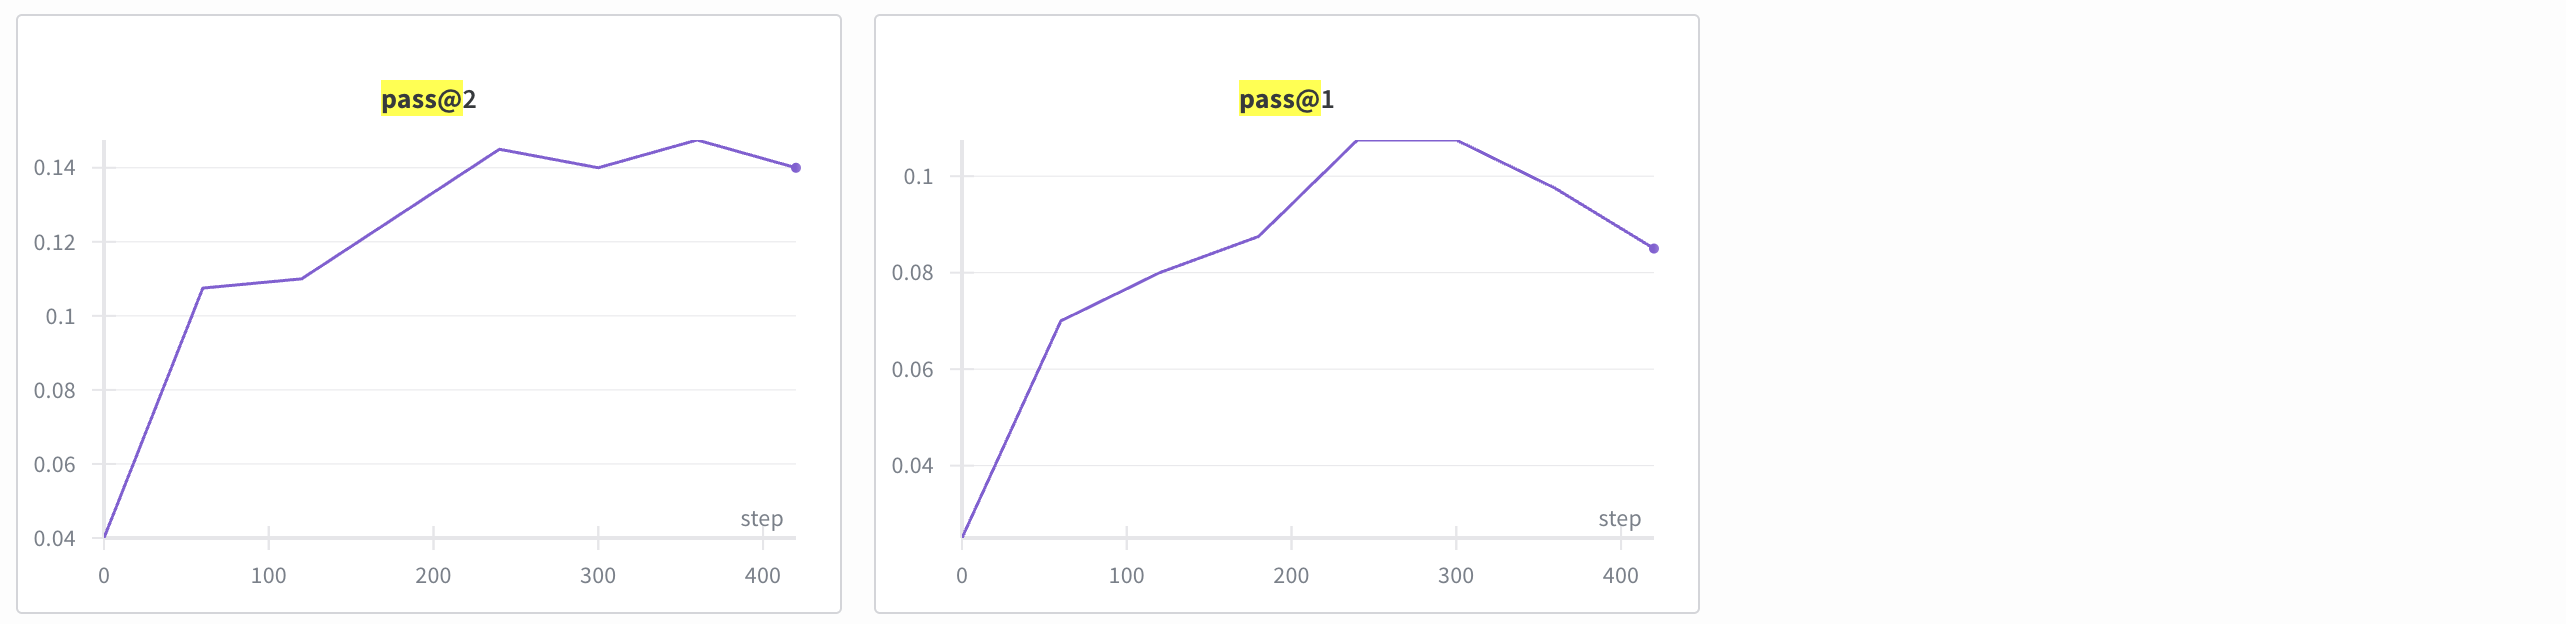


TODO: back on GPU machine could be helpfult to look at examples that it gets right and later gets wrong. Would also be good to know if there are examples that once it gets right it "always" gets right or is there a lot of flipflopping in how it's getting to say a peak of ~10% for pass@1 or ~28% for pass@8. Eval_examples is set to 400. This means pass@1 goes:

```
Step  # Right
0     10
60    28
120   32
180   35
240   43
300   43
360   39
420   34
```

TODO: run with a bigger number of eval_examples and see if the trends stays the same.

Could be good to look at things like this:

```

Example ->  0  1  2  3 ... 399
Step ▼
0           0  0  0  1 ... 0
60          0  1  0  1 ... 0
120         0  0  0  1 ... 0
...
420         0  0  1  0 ... 0
```

Where 0 means wrong and 1 means right. Then could pick out specific examples and look at them.

See what ChatGPT says.

When doing reinforcement learning, why might pass@k decline after a certain point?

ChatGPT: In reinforcement learning (RL), a decline in pass@k (especially in program synthesis or code-generation tasks) after some training point is typically a sign of policy collapse or over-optimization, where the model begins optimizing for the reward in a way that harms true generalization or diversity.

...and then a bunch of pretty interesting list of common reasons.